In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


TensorFlow version: 1.10.0
Keras version: 2.2.2


In [3]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
import keras.callbacks
import cv2
import pandas as pd
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
sess = tf.Session()
K.set_session(sess)
K.set_image_data_format("channels_last")

In [5]:
from VLP_preprocess import *
from ImageAugmentation import *

# Get alphabet

In [6]:
SAVE_MODEL = False

In [7]:
label_path = "./data/train-data-label.txt"
image_dir = "./data/train-data/"
model_save_path = './saved_model.h5'

In [8]:
img_w_target = 356
img_h_target = 70
img_channel_target = 3
str_len = 9
batch_size = 32
train_test_ratio = 0.1

In [9]:
label_df = pd.read_csv(label_path, header=-1, names=['license', 'image_path'], skipinitialspace=True)
label_df.head()

,license,image_path
0,京WGEV8PG9,2b02495a8701b118.jpg
1,秦R75BNAQB,2b02495b8ae41c5a.jpg
2,深K14P48AM,2b070e1484af3a96.jpg
3,杭THTZEL30,2b097074bfb77c2d.jpg
4,海JE242914,2b0970759f239c93.jpg


In [10]:
license_max_length = label_df.license.map(len).max()
license_min_length = label_df.license.map(len).min()
print("license max/min length: {}, {}".format(license_max_length, license_min_length))

strs = ""
for license in label_df.license.values:
    strs += license
str_set = list(set(strs))
print("license str set length: {}".format(len(str_set)))
print("license str set: {}".format(str_set))

str_label_dict = {}
for i, s in enumerate(str_set):
    str_label_dict[s] = i
print("str_label_dict is: {}".format(str_label_dict))

license max/min length: 9, 9
license str set length: 43
license str set: ['V', 'B', '海', '6', '松', 'N', '2', 'S', '成', '深', '苏', '杭', 'C', 'K', 'R', 'W', 'D', '南', '3', 'G', 'F', 'X', 'Z', 'Y', '京', '5', '4', 'Q', 'H', 'E', 'P', '7', 'A', '8', '秦', 'L', '1', 'U', '9', '0', 'J', 'T', 'M']
str_label_dict is: {'V': 0, 'B': 1, '海': 2, '6': 3, '松': 4, 'N': 5, '2': 6, 'S': 7, '成': 8, '深': 9, '苏': 10, '杭': 11, 'C': 12, 'K': 13, 'R': 14, 'W': 15, 'D': 16, '南': 17, '3': 18, 'G': 19, 'F': 20, 'X': 21, 'Z': 22, 'Y': 23, '京': 24, '5': 25, '4': 26, 'Q': 27, 'H': 28, 'E': 29, 'P': 30, '7': 31, 'A': 32, '8': 33, '秦': 34, 'L': 35, '1': 36, 'U': 37, '9': 38, '0': 39, 'J': 40, 'T': 41, 'M': 42}


In [11]:
# 构建数据库df
label_df["label"] = label_df.license.map(lambda x: [str_label_dict[s] for s in x])
def read_img(path):
    path = image_dir + path
    img = cv2.imread(path)

    return img

label_df["image"] = label_df.image_path.map(read_img)
label_df["shape"] = label_df.image.map(lambda x: x.shape)

In [12]:
label_df.head()

,license,image_path,label,image,shape
0,京WGEV8PG9,2b02495a8701b118.jpg,"[24, 15, 19, 29, 0, 33, 30, 19, 38]","[[[11, 2, 0], [41, 0, 0], [114, 2, 10], [138, ...","(70, 296, 3)"
1,秦R75BNAQB,2b02495b8ae41c5a.jpg,"[34, 14, 31, 25, 1, 5, 32, 27, 1]","[[[11, 2, 0], [41, 0, 0], [114, 2, 10], [138, ...","(70, 296, 3)"
2,深K14P48AM,2b070e1484af3a96.jpg,"[9, 13, 36, 26, 30, 26, 33, 32, 42]","[[[19, 0, 0], [46, 0, 0], [111, 2, 11], [133, ...","(70, 296, 3)"
3,杭THTZEL30,2b097074bfb77c2d.jpg,"[11, 41, 28, 41, 22, 29, 35, 18, 39]","[[[25, 0, 0], [50, 0, 0], [109, 3, 10], [129, ...","(70, 296, 3)"
4,海JE242914,2b0970759f239c93.jpg,"[2, 40, 29, 6, 26, 6, 38, 36, 26]","[[[25, 0, 0], [50, 0, 0], [109, 3, 10], [129, ...","(70, 296, 3)"


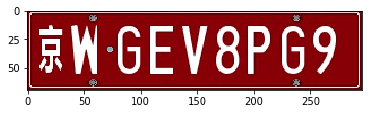

In [13]:
plt.imshow(label_df.image[0])

# 训练集、测试集划分

In [14]:
train_ids, valid_ids = train_test_split(range(label_df.shape[0]), test_size=train_test_ratio)

In [15]:
train_df = label_df.iloc[train_ids]
valid_df = label_df.iloc[valid_ids]

# Input data generator

In [16]:
from tqdm import tqdm
class LicenseDataGenerator:
    def __init__(self, 
                 df,
                 img_w, img_h, img_channel,
                 batch_size, 
                 str_len,
                 transform=False):
        
        self.df = df
        self.img_h = img_h
        self.img_w = img_w
        self.img_channel = img_channel
        self.batch_size = batch_size
        self.str_len = str_len
        if transform:
            self.transform = ImageAugmentation().transform
        else:
            self.transform = None
        
        self.vp = VLPPreProcess(img_w, img_h, img_channel)
        self.n = df.shape[0]
        self.cur_index = 0
        self.build_data()
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_w, self.img_h, self.img_channel), dtype=np.float32)
        self.texts = np.zeros((self.n, self.str_len))
        for i in tqdm(range(self.n)):
            row = self.df.iloc[i]
            img = row.image
            img = self.vp.image_correct(img)
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :, :] = img
            label = row.label
            self.texts[i] = np.array(label, dtype=np.float32)

    def batch_generator(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            assert K.image_data_format() == 'channels_last'
            
            if self.cur_index + self.batch_size >= self.n:
                X_data = self.imgs[-self.batch_size:, :, :, :].copy()
                Y_data = self.texts[-self.batch_size:, :]
                self.cur_index = 0
            else:
                X_data = self.imgs[self.cur_index: self.cur_index + self.batch_size, :, :, :].copy()
                Y_data = self.texts[self.cur_index: self.cur_index + self.batch_size, :]

            if self.transform is not None:
                for i in range(X_data.shape[0]):
                    X_data[i] = self.transform(X_data[i])
                
            pool_size = 2
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // pool_size ** 3 - 2)
            label_length = np.ones((self.batch_size, 1)) * (self.str_len)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            
            yield (inputs, outputs)
            
            self.cur_index += self.batch_size

In [17]:
train_data_generator = LicenseDataGenerator(train_df, img_w_target, img_h_target, img_channel_target, batch_size, 9, True)
valid_data_generator = LicenseDataGenerator(valid_df, img_w_target, img_h_target, img_channel_target, batch_size, 9)

100%|██████████| 400/400 [00:12<00:00, 30.88it/s]


# Loss and train functions, network architecture

In [18]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
#     the 2 is critical here since the first couple outputs of the RNN
#     tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def build_model(load=False):
    assert K.image_data_format() == 'channels_last'
    
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512
    
    input_shape = (img_w_target, img_h_target, img_channel_target)

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(16, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(32, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
    inner = Conv2D(64, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv3')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max3')(inner)

    conv_to_rnn_dims = (img_w_target // (pool_size ** 3), (img_h_target // (pool_size ** 3)) * 64)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(len(str_set) + 1, kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    model = Model(inputs=input_data, outputs=y_pred)
    model.summary()
    

    labels = Input(name='the_labels', shape=[str_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    if load:
        model = load_model(model_save_path, compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    

    return model

In [19]:
model = build_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 356, 70, 3)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 356, 70, 16)  448         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 178, 35, 16)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 178, 35, 32)  4640        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [20]:
# captures output of softmax so we can decode the output during visualization
# test_func = K.function([input_data], [y_pred])

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

history = model.fit_generator(generator=train_data_generator.batch_generator(),
                              steps_per_epoch=(train_data_generator.n + batch_size - 1) // batch_size,
                              epochs=40,
                              validation_data=valid_data_generator.batch_generator(), 
                              validation_steps=(valid_data_generator.n+ batch_size - 1) // batch_size,
                              callbacks=[early])

Epoch 1/40
113/113 [==============================] - 35s 313ms/step - loss: 44.2431 - val_loss: 34.9123
Epoch 2/40
113/113 [==============================] - 31s 275ms/step - loss: 33.7678 - val_loss: 32.9437
Epoch 3/40
113/113 [==============================] - 31s 274ms/step - loss: 32.2438 - val_loss: 31.6296
Epoch 4/40
113/113 [==============================] - 31s 275ms/step - loss: 30.7686 - val_loss: 29.8223
Epoch 5/40
113/113 [==============================] - 31s 272ms/step - loss: 28.9305 - val_loss: 27.7952
Epoch 6/40
113/113 [==============================] - 31s 271ms/step - loss: 27.0649 - val_loss: 26.4097
Epoch 7/40
113/113 [==============================] - 31s 271ms/step - loss: 25.3539 - val_loss: 24.7198
Epoch 8/40
113/113 [==============================] - 31s 270ms/step - loss: 23.6962 - val_loss: 22.8801
Epoch 9/40
113/113 [==============================] - 31s 272ms/step - loss: 17.3762 - val_loss: 6.2167
Epoch 10/40
113/113 [==============================] - 3

# Function to decode neural network output

In [21]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

# 解码CTC层的输出，因为输出固定是9个字符
# 所以解码时如果超出9个字符就选择概率最低的丢弃，如果小于9个字符，就慢慢降低blank的概率直至解码够9个字符
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        for i in range(15):
            temp = out[j, 2:]
            temp[:, -1] = temp[:, -1] * 0.9**i
            out_best = list(np.argmax(temp, 1))
            out_label = []
            probs = []
            i_cnt = 2
            for k, g in itertools.groupby(out_best):
                lg = list(g)
                if k < len(str_set):
                    out_label.append(k)
                    probs.append(max(out[j, i_cnt:i_cnt+len(lg), k]))
                i_cnt += len(lg)
            
            if len(out_label) >= str_len:
                break

        while len(out_label) > str_len:
            # 选择概率最小的丢弃
            del_i = probs.index(min(probs))
            probs.pop(del_i)
            out_label.pop(del_i)
            
        outstr = ''
        for c in out_label:
            if c < len(str_set):
                outstr += str_set[c]
            
        ret.append(outstr)
        
    return ret

# Test on validation images

Predicted: 	南ZF07AB8X
True: 		南ZF07AB8X


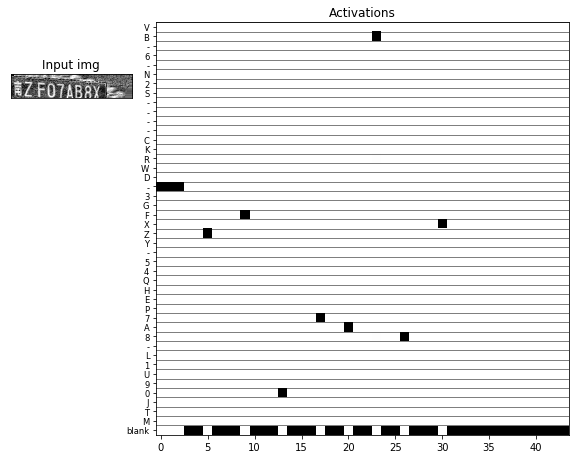

Predicted: 	南A389WE23
True: 		南A389WE23


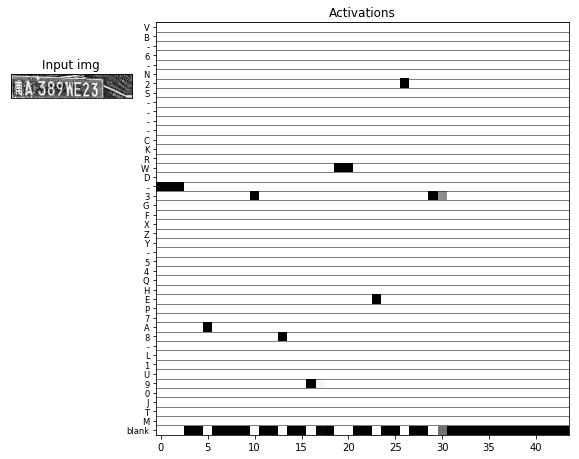

Predicted: 	深SUF04XTB
True: 		深SUF04X1B


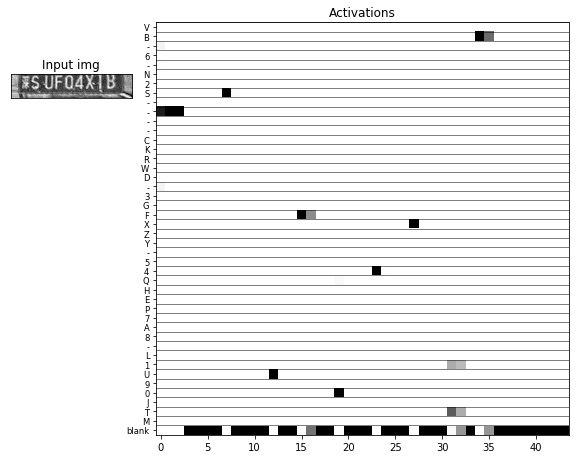

Predicted: 	苏LWRSZ8W6
True: 		苏LWRSZ8W6


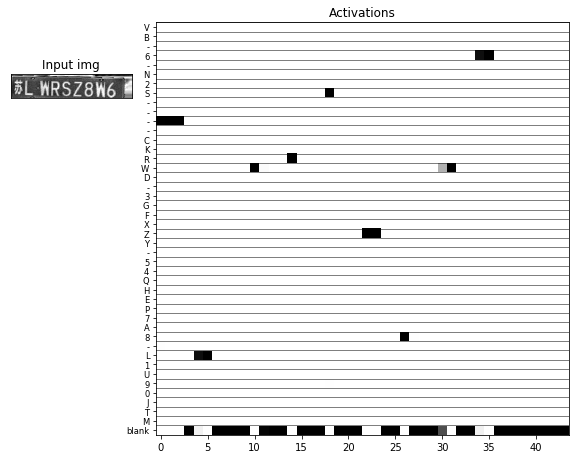

Predicted: 	京JWFF8MQ6
True: 		京JWFF8MQ6


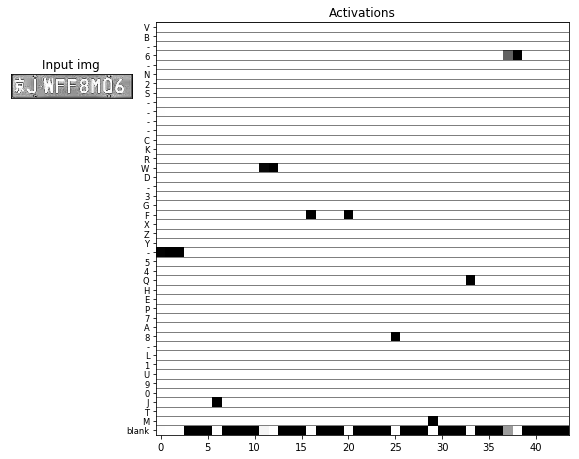

Predicted: 	京DE2KZD9G
True: 		京DE2KZD2L


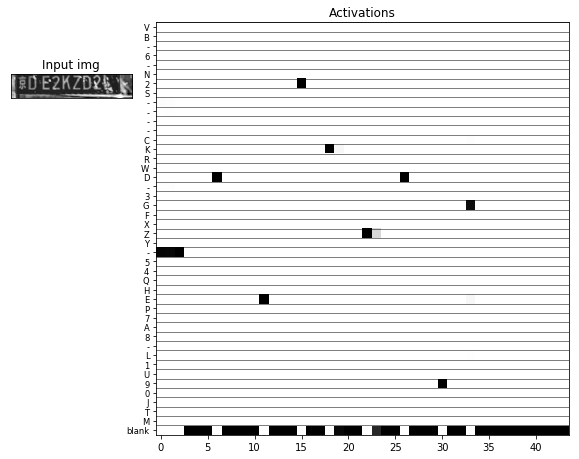

Predicted: 	杭F9CL2U5G
True: 		杭F9CL2U5G


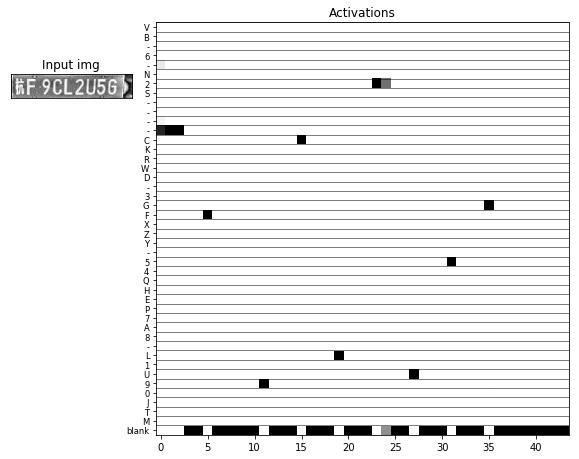

Predicted: 	成F8G0EFTR
True: 		成F8G0EFTR


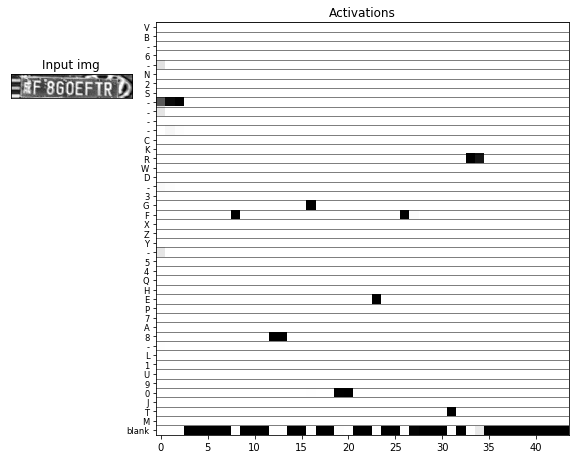

Predicted: 	成Y72N2HJ6
True: 		成Y72N2HJ6


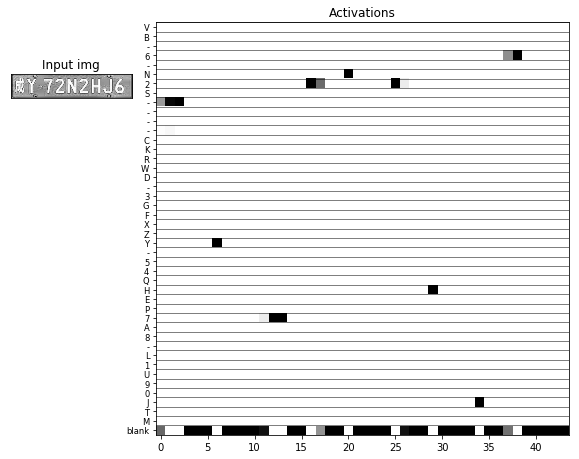

Predicted: 	杭CCVP2YY6
True: 		杭CCVP2YY6


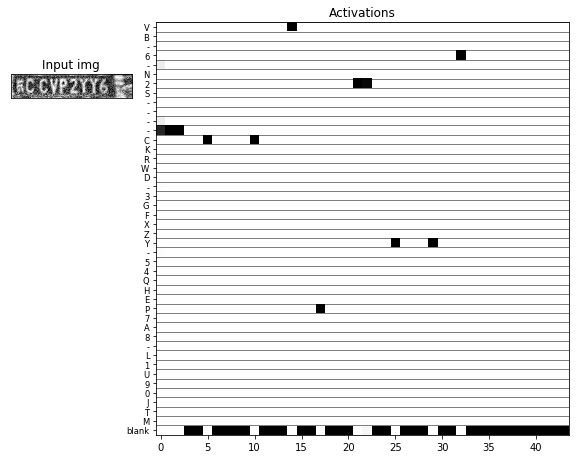

Predicted: 	海A8G9T4HX
True: 		海A869T41D


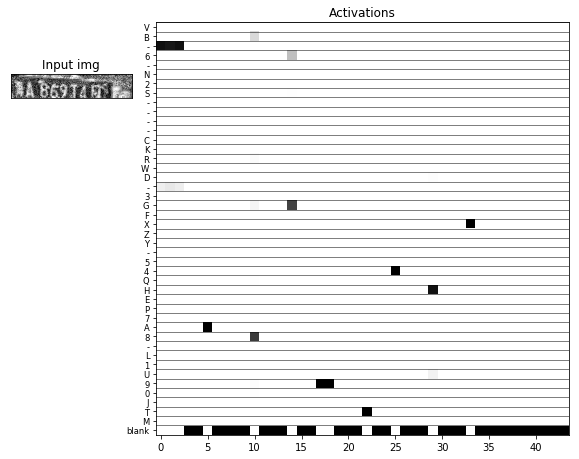

Predicted: 	成XUQ627EC
True: 		成XU5627EC


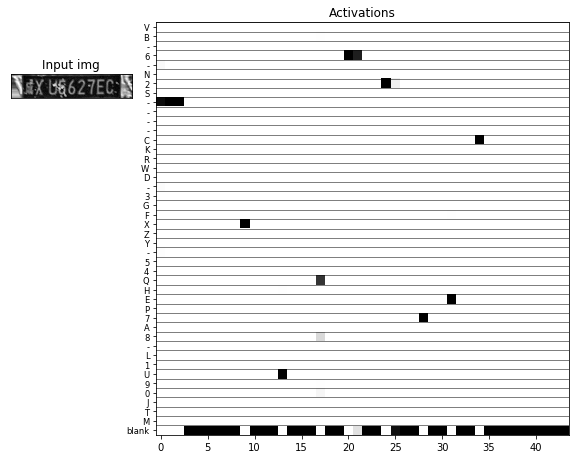

Predicted: 	苏EDPE65VZ
True: 		苏EDPE65VZ


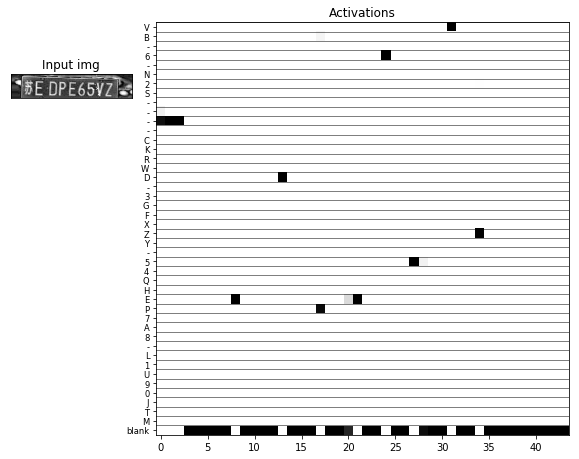

Predicted: 	海L1RAQL3E
True: 		海L1RAQL3E


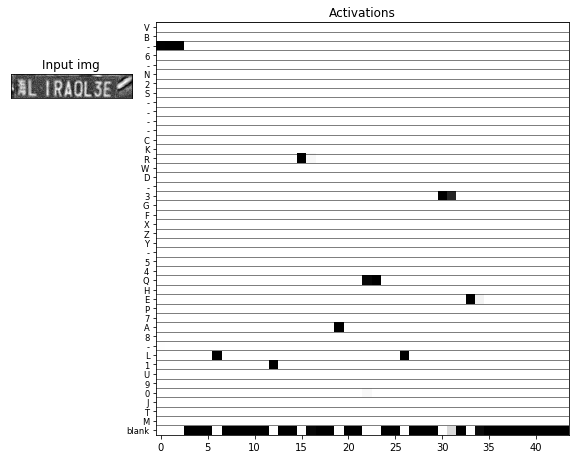

Predicted: 	苏SLWEND68
True: 		苏SLWEND68


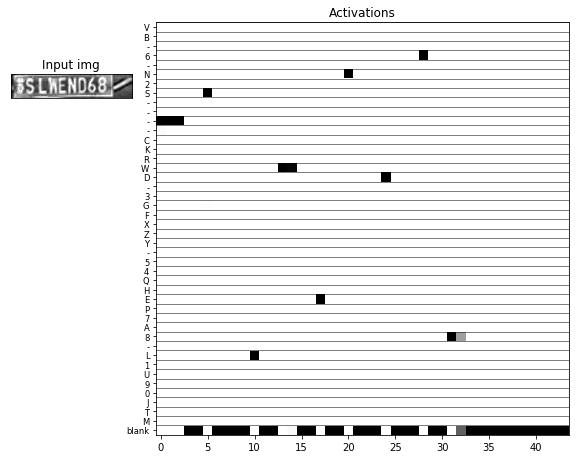

Predicted: 	秦RHRBB2Z9
True: 		秦RHRPB2Z9


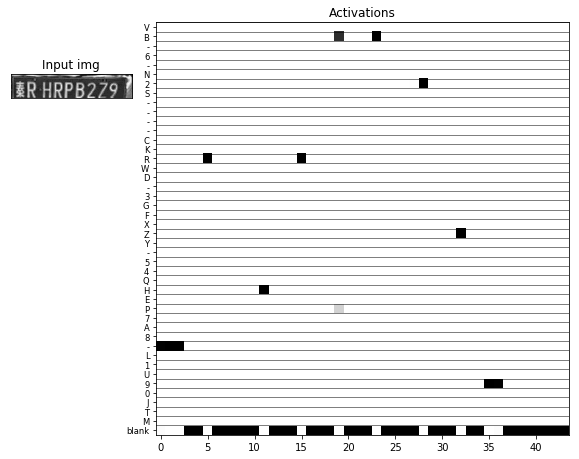

Predicted: 	杭PUZXUQ32
True: 		杭PUZXUQ32


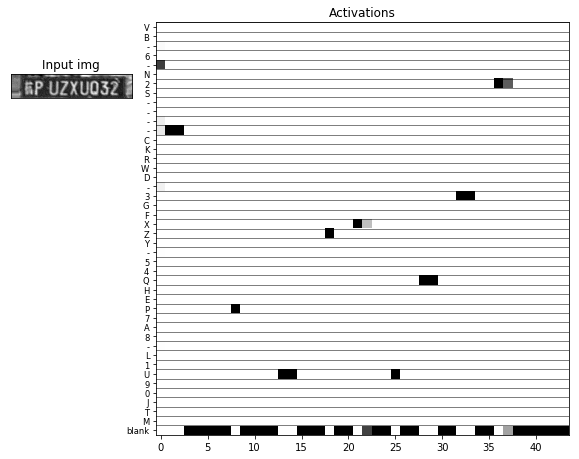

Predicted: 	南YPETXS42
True: 		南YPETXS42


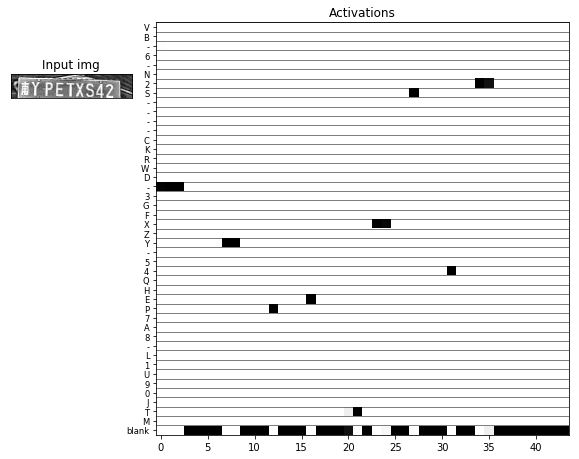

Predicted: 	成ME8RA6VW
True: 		成ME8RA6VW


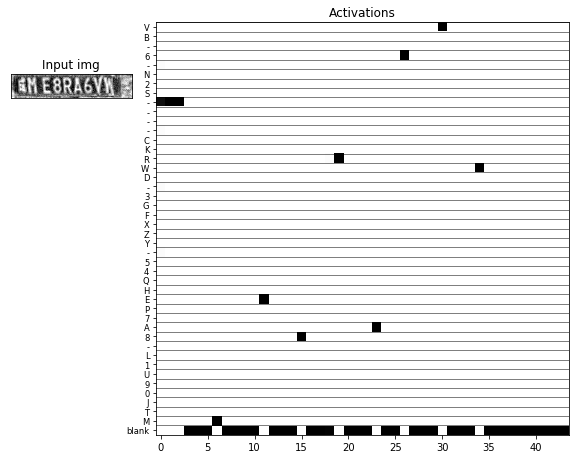

Predicted: 	松YFL5AQ0N
True: 		松YFL5AQC3


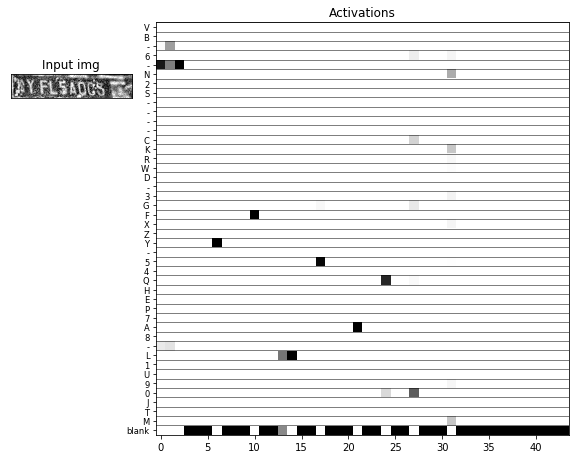

Predicted: 	杭GHD7TLX0
True: 		杭GHD7TLX0


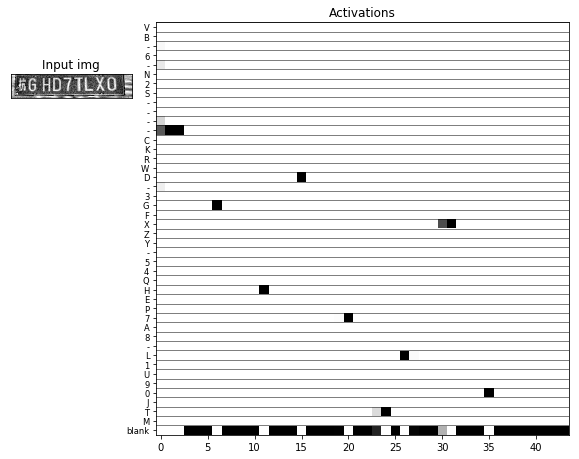

Predicted: 	南XLWU6U0E
True: 		南XLWU6U0E


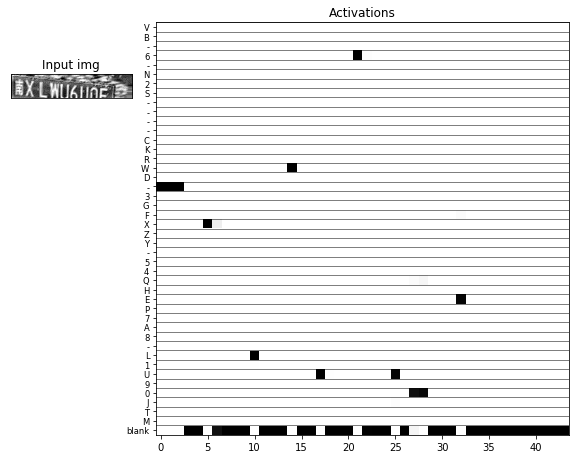

Predicted: 	成V5FCEPY7
True: 		成V5FCEPY7


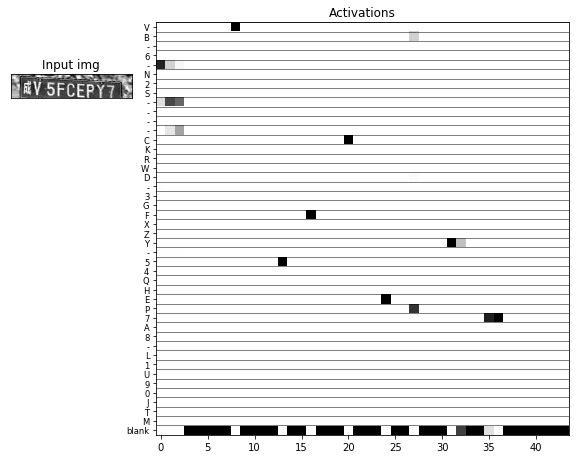

Predicted: 	成GJQGXA58
True: 		成GJQGXA58


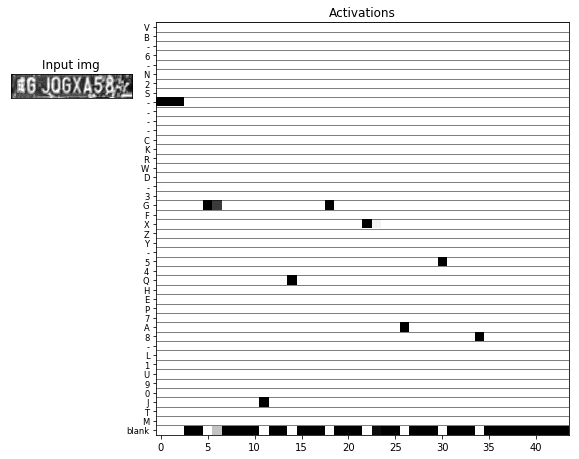

Predicted: 	海WXS51BUE
True: 		海WXS51BUE


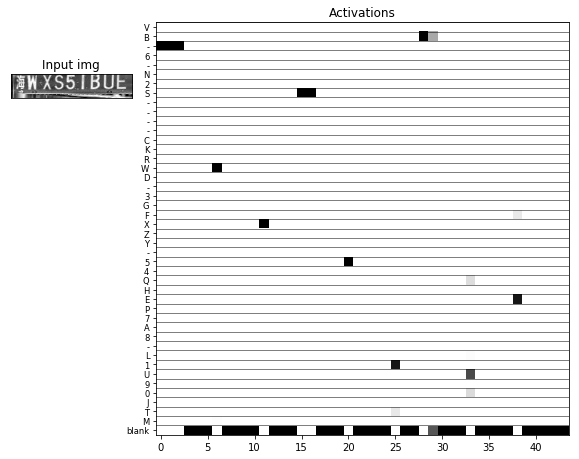

Predicted: 	京TNH5UH4S
True: 		京TNH5UH4S


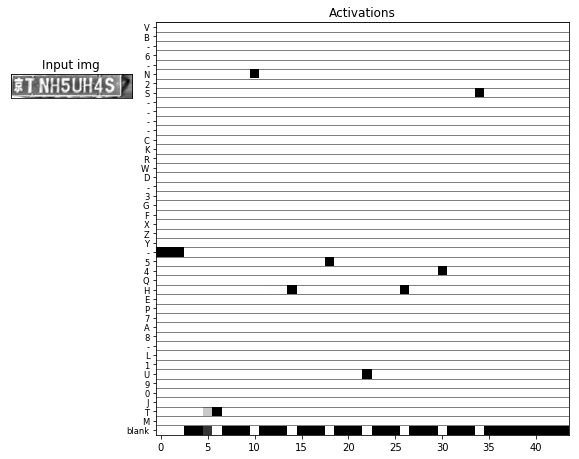

Predicted: 	海HRKFM0U4
True: 		海HRKFM0U4


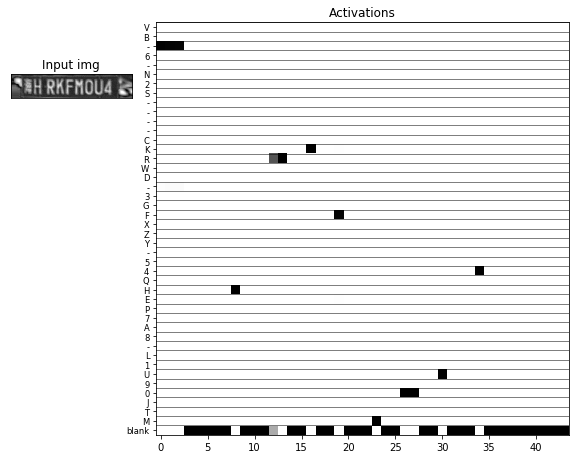

Predicted: 	成YT66VLGV
True: 		成YT66VLGV


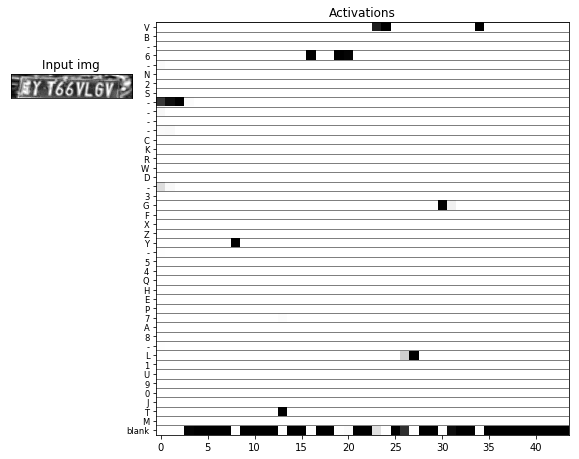

Predicted: 	深SB07WF2D
True: 		深SB07WF2D


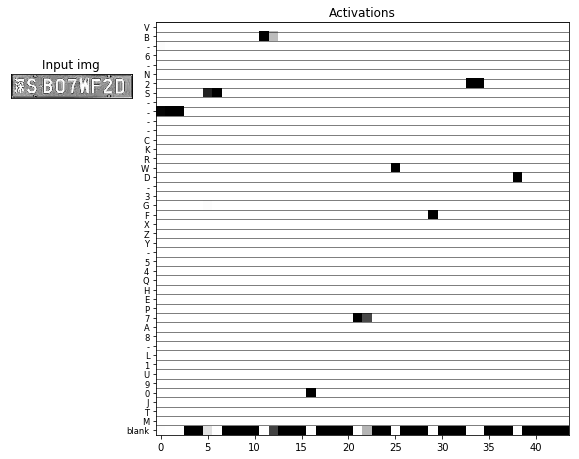

Predicted: 	秦JSPL9W4F
True: 		秦JSPL9W4F


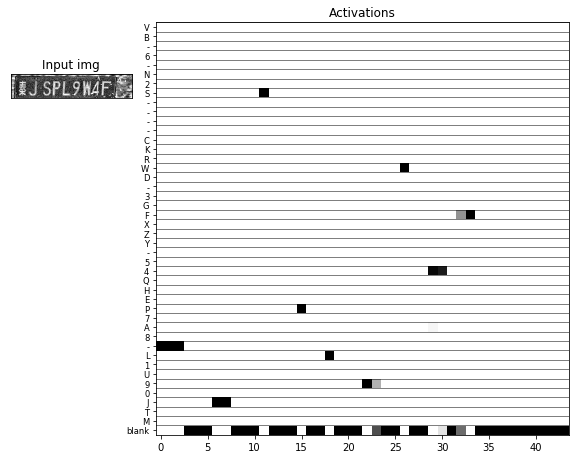

Predicted: 	松HMURPF06
True: 		松HMURPF06


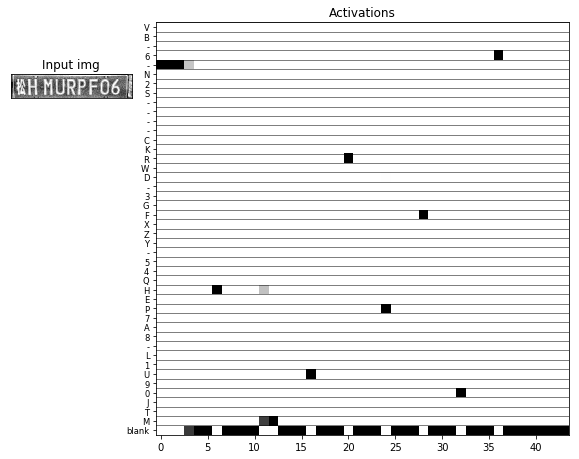

Predicted: 	杭S1B5EEQC
True: 		杭S1B5EEQC


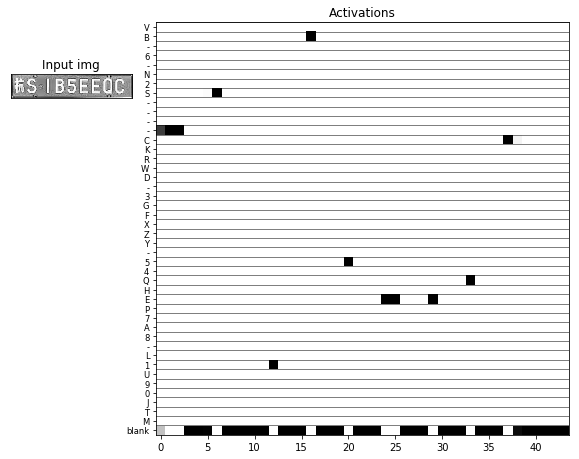

In [22]:
net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

str_set_no_chinese = []
for s in str_set:
    if '\u4e00' <= s <= '\u9fff':
        str_set_no_chinese.append("-")
    else:
        str_set_no_chinese.append(s)

for inp_value, _ in valid_data_generator.batch_generator():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: str_set[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 4, wspace=0.2, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0, 0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[:, 1:])
        fig.add_subplot(ax2)
        print('Predicted: \t%s\nTrue: \t\t%s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Activations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(str_set) + 1)))
        ax2.set_yticklabels(list(str_set_no_chinese) + ['blank'], fontsize="small")
        ax2.grid(False)
        for h in np.arange(-0.5, len(str_set) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

In [26]:
# 计算评价指标
true_cnt = 0
all_cnt = 0
for inp_value, _ in valid_data_generator.batch_generator():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: str_set[int(x)], label)))
        texts.append(text)
        
    for i in range(bs):
        pred = pred_texts[i]
        true = texts[i]
        for j in range(len(true)):
            if j < len(pred):
                if pred[j] == true[j]:
                    true_cnt += 1
                    
            all_cnt += 1
            
        if len(pred) != len(true):
            print("all_cnt: {}, pred true are not same len: {}, {}".format(all_cnt, pred, true))
            
    if all_cnt >= len(valid_df) * 9:
        break
            
print("acc is: {}, Ca is: {}".format(true_cnt/all_cnt, all_cnt/true_cnt))

acc is: 0.9818376068376068, Ca is: 1.0184983677910773


In [27]:
model_no_loss_layer = Model(model.get_layer(name='the_input').input, model.get_layer(name='softmax').output)

In [28]:
if SAVE_MODEL:
    builder = tf.saved_model.builder.SavedModelBuilder("./model")
    g = tf.get_default_graph()
    inp = g.get_tensor_by_name(model_no_loss_layer.input.name)
    out = g.get_tensor_by_name(model_no_loss_layer.output.name)

    predict_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    inputs={"images": inp},
    outputs={"scores" : out})
    
    sigs = {tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
            predict_signature}

    builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING], signature_def_map=sigs)
    builder.save()